# Processo de difusão

treinar modelo com dados adicionando ruídos para prever a imagem original a partir de uma imagem com ruído, por exemplo

density = true faz com que o histograma retorno a densidade da probabilidade

Quanto maior o **desvio padrão** (σ), mais variados os valores são da média

**Média** é o centro da distribuição, ponto com maior densidade

A distribuição é definida pela média e desvio padrão(chamado de variância, σ$^2$). 

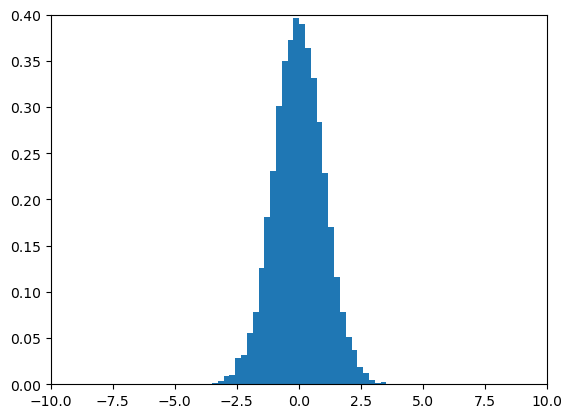

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_hist(values):
    plt.hist(values, bins=30, density=True)
    plt.xlim((-10,10))
    plt.ylim((0, 0.4))
    
values = torch.randn(10000)
plot_hist(values)

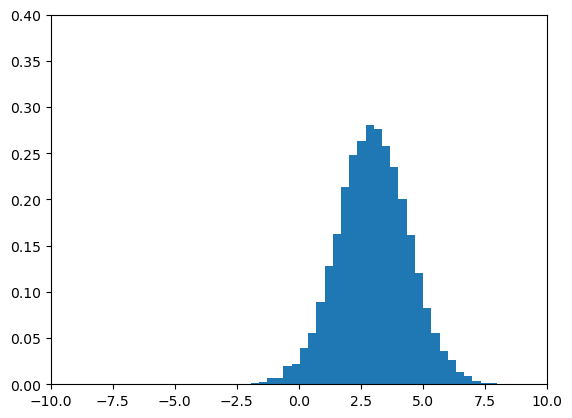

In [7]:
media = 3
var = 9
values2 = var**0.5*values + media
plot_hist(values2)